# gather and format data

In [128]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import h5py
import timeit

df = pd.read_csv('sensor_sit_2_clean.csv')
df.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow = pd.read_csv('flow_sit_2_clean.csv')
flow.columns = ['Flow']

In [129]:
def scaleFlow(flow):
    
    flow_scaled = []
    
    for i in range(0, len(flow)):
        
        flow_scaled.append((flow['Flow'][i] - min(flow['Flow'])) / (max(flow['Flow']) - min(flow['Flow'])))
        
    return pd.DataFrame(flow_scaled, columns = ['Flow'])

flow = scaleFlow(flow)

def movingAvg(Class, windowSize):
    """
    Create moving average to remove single outliers

    Args:
        Class (list): List of inhale / exhale classes
        Windowsize (int): Size of moving average window

    Returns:
        filteredClass (list): Filtered list of classes
    """
    
    filteredClass = []
    for i in range(0, len(Class)):

        if i < windowSize - 1:
            filteredClass.append(Class[i])

        elif Class[i] != Class[i - 1]:
            if sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize > 1:
                filteredClass.append(2)

            elif sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize < 1:
                filteredClass.append(0)

            else:
                filteredClass.append(Class[i])

        elif Class[i] == Class[i - 1]:
            filteredClass.append(Class[i])
            
    return filteredClass

def classSwitch(Class):
    """
    Class switch function to filter 3 classifiers down to 2 (inhale and exhale)

    Args:
        Class (list): List of inhale / exhale classes

    Returns:
        decisionClass (list): Filtered (with moving average) of resulting simplified class
    """

    decision = []
    for i in range(0, len(Class)):
        
        if Class[i] == 1:
            decision.append(1)
            
        elif Class[i] == 0:
            decision.append(0)
            
        elif Class[i] == 2:
            if len(decision) > 1:
                decision.append(decision[-1])
            else:
                decision.append(2)
            
    return movingAvg(decision, 3)

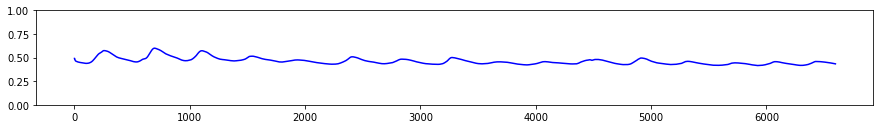

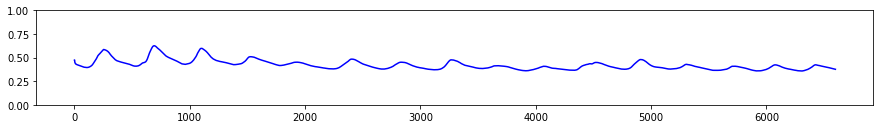

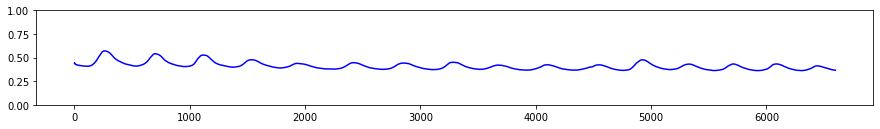

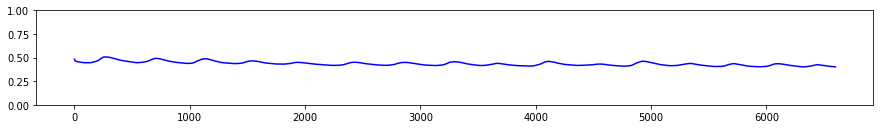

In [130]:
x = range(0, len(df))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.ylim(0, 1)
plt.plot(x, df['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.ylim(0, 1)
plt.plot(x, df['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.ylim(0, 1)
plt.plot(x, df['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.ylim(0, 1)
plt.plot(x, df['4'], 'b')
plt.show()

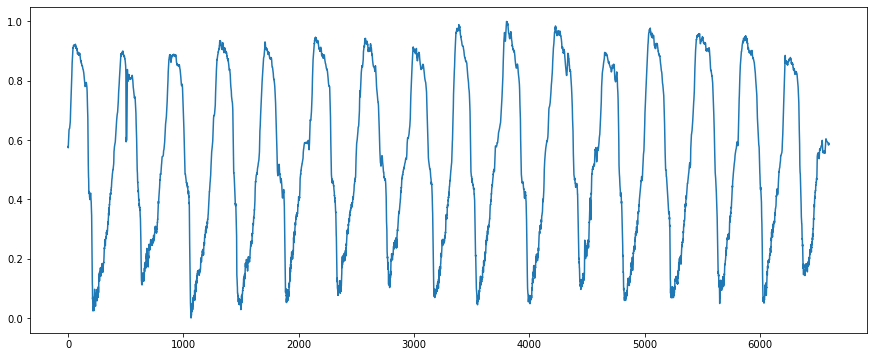

In [131]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow['Flow'])

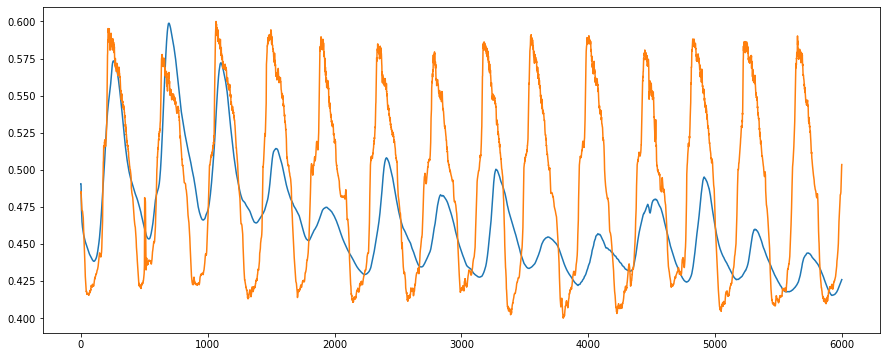

In [132]:
x = range(0, len(df['4'][0:6000]))
flow['a'] = (flow['Flow'] / 5) - 0.6
fig = plt.figure(figsize = (15, 6))
plt.plot(x, df['1'][0:6000], x, flow['a'][0:6000]*-1)

In [133]:
flow.drop('a', inplace = True, axis = 1)

In [134]:
def classLabel(flow):

    upper = 0.8
    lower = 0.25
    
    state = []
    action = []

    for i in range(0, len(flow)):

        if i > len(flow)-2:
            state.append(2)

        else:

            if flow['Flow'][i] < upper and flow['Flow'][i+1] > upper:
                action.append(2)

            if flow['Flow'][i] < lower and flow['Flow'][i+1] > lower:
                action.append(1)

            if flow['Flow'][i] > lower and flow['Flow'][i+1] < lower:
                action.append(2)

            if flow['Flow'][i] > upper and flow['Flow'][i+1] < upper:
                action.append(0)

            if len(action) > 1:
                state.append(action[-1])

            else:
                state.append(2)
                
    return state

df['Class'] = classLabel(flow)

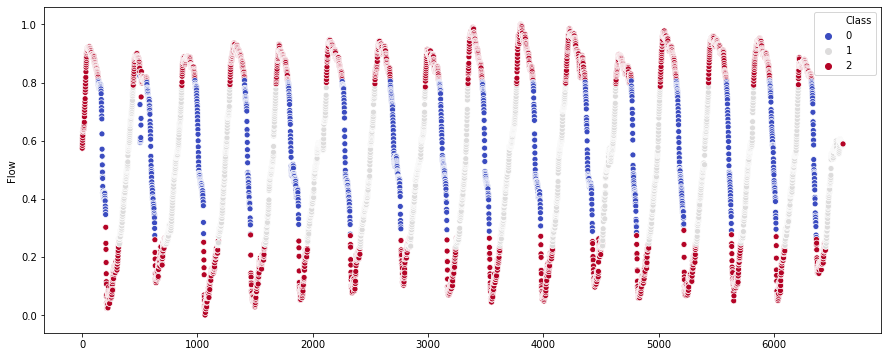

In [135]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow['Flow'], x = range(0, len(flow)), hue = df['Class'], palette = 'coolwarm')

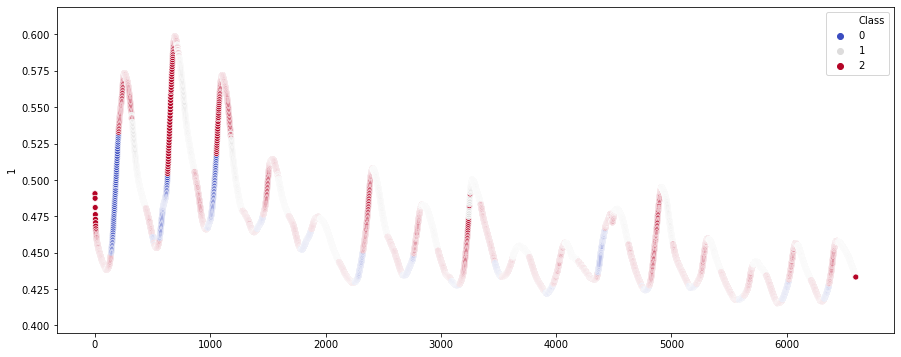

In [136]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df['1'], x = range(0, len(df)), hue = df['Class'], palette = 'coolwarm')

In [137]:
df = df[500:]
flow = flow[500:]

In [138]:
# Create the data matrix
X = df.drop('Class', axis = 1)
X.drop('hours', inplace = True, axis = 1)
X.drop('minutes', inplace = True, axis = 1)
X.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
y = df['Class']
y = pd.DataFrame(y, index = None, columns = ['Class'])

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)

# model training - random forest

In [139]:
print(" Random Forest ... ")

start = timeit.default_timer()
classifier = RandomForestClassifier(n_estimators = 50000)
rf_model = classifier.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
end = timeit.default_timer()

print(" accuracy = ", accuracy_score(y_test, predictions), " time = ", end - start)
print(confusion_matrix(y_test, predictions))
print("\n")

print("Random Forest")
print(classification_report(y_test, predictions))

 Random Forest ... 


/Users/mikefurr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


 accuracy =  0.9781420765027322  time =  221.62685136500022
[[280   0   9]
 [  0 554  14]
 [  6  11 956]]


Random Forest
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       289
           1       0.98      0.98      0.98       568
           2       0.98      0.98      0.98       973

    accuracy                           0.98      1830
   macro avg       0.98      0.98      0.98      1830
weighted avg       0.98      0.98      0.98      1830



In [140]:
Predictions = classSwitch(predictions)
Class = classSwitch(list(y_test['Class']))
print('Random Forest')
print("\n")
print(classification_report(Class, Predictions))

Random Forest


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       803
           1       0.98      0.99      0.98      1024
           2       1.00      1.00      1.00         3

    accuracy                           0.98      1830
   macro avg       0.99      0.99      0.99      1830
weighted avg       0.98      0.98      0.98      1830



# model testing on new data

In [141]:
df_test = pd.read_csv('sensor_sit_1_clean.csv')
df_test.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']
flow_test = pd.read_csv('flow_sit_1_clean.csv')
flow_test.columns = ['Flow']
flow_test = scaleFlow(flow_test)

In [142]:
df_test['Class'] = classLabel(flow_test)

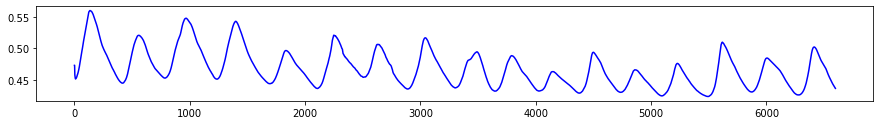

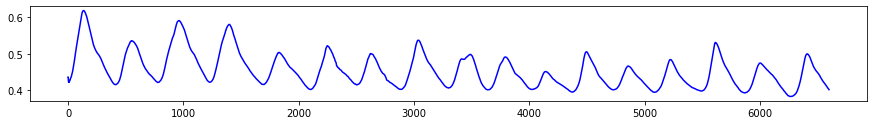

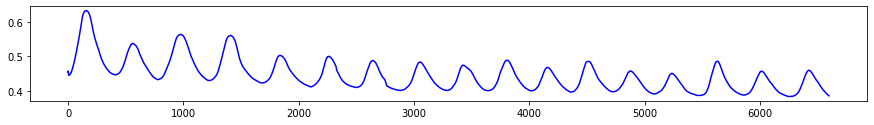

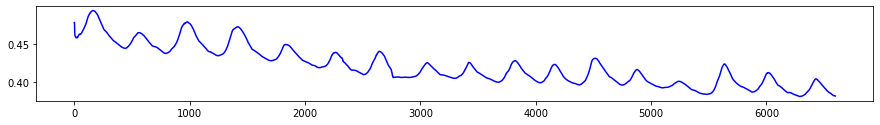

In [143]:
x = range(0, len(df_test))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)

plt.plot(x, df_test['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.plot(x, df_test['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.plot(x, df_test['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.plot(x, df_test['4'], 'b')
plt.show()

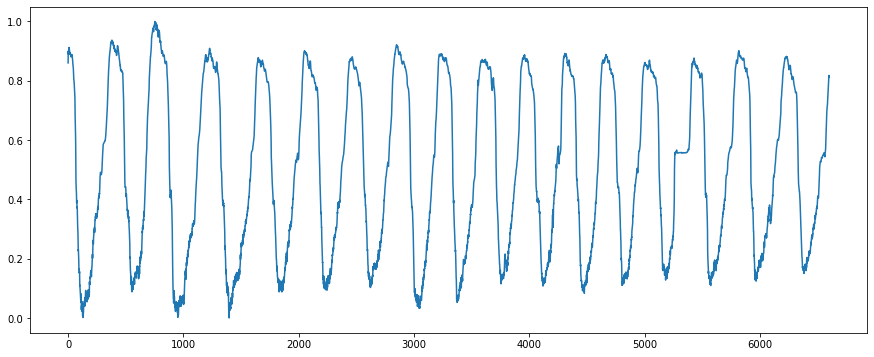

In [144]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow_test['Flow'])

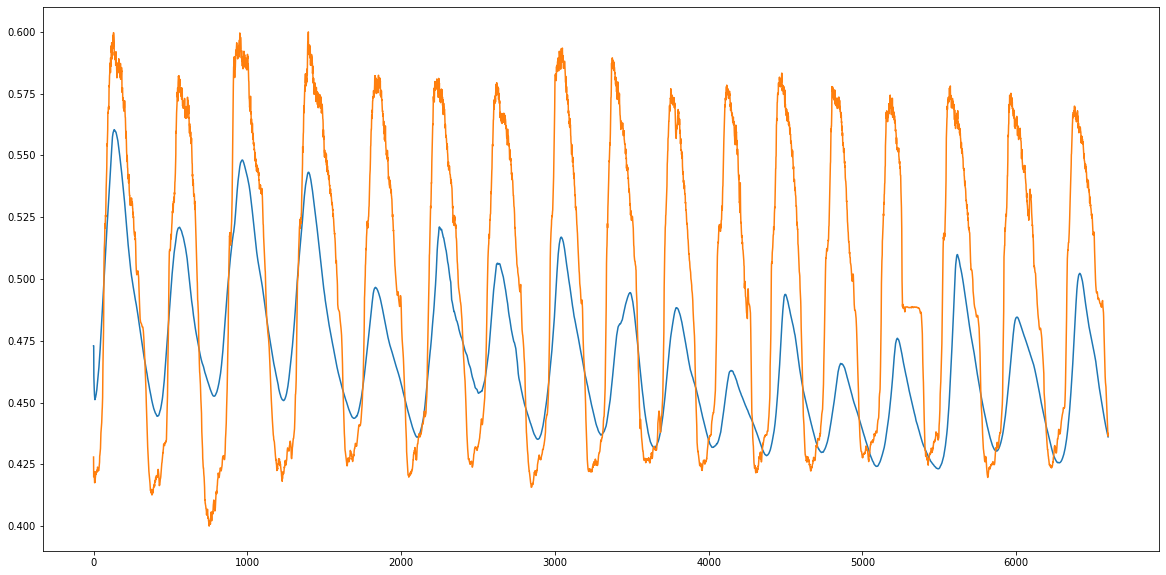

In [145]:
flow_test['a'] = (flow_test['Flow'] / 5) - 0.6
fig = plt.figure(figsize = (20, 10))
plt.plot(x, df_test['1'], x, flow_test['a']*-1)

In [146]:
flow_test.drop('a', inplace = True, axis = 1)

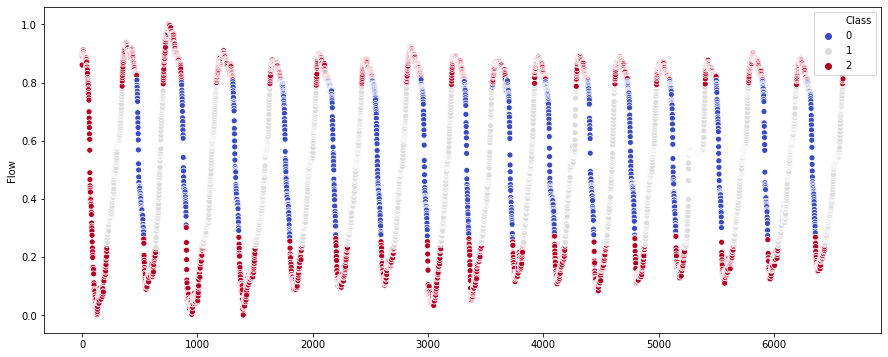

In [147]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'], x = range(0, len(flow_test)), hue = df_test['Class'], palette = 'coolwarm')

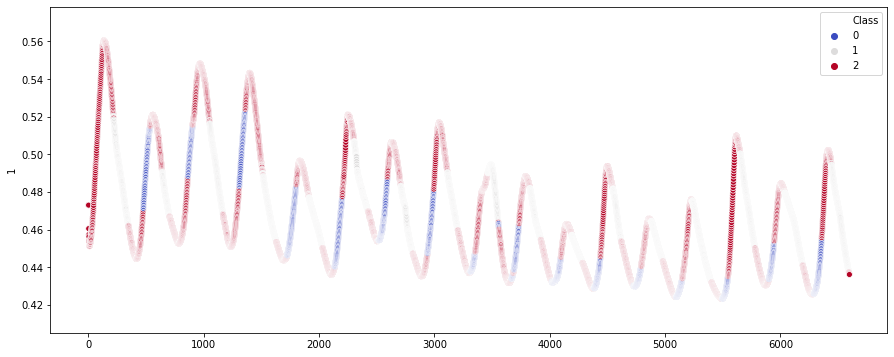

In [148]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df_test['1'], x = range(0, len(df_test)), hue = df_test['Class'], palette = 'coolwarm')

In [149]:
test_sensors = df_test.drop('Class', axis = 1)
test_sensors.drop('hours', inplace = True, axis = 1)
test_sensors.drop('minutes', inplace = True, axis = 1)
test_sensors.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
test_class = df_test['Class']
test_class = pd.DataFrame(test_class, index = None, columns = ['Class'])

# model testing - random forest

In [150]:
test_predictions = rf_model.predict(test_sensors)
print(" accuracy = ", accuracy_score(test_class, test_predictions))
print(confusion_matrix(test_class, test_predictions))
print("\n")

print('Random Forest - Testing')
print('\n')
print(classification_report(test_class, test_predictions))

 accuracy =  0.6028186088801334
[[ 366  164  408]
 [  22 1710  202]
 [ 225 1600 1902]]


Random Forest - Testing


              precision    recall  f1-score   support

           0       0.60      0.39      0.47       938
           1       0.49      0.88      0.63      1934
           2       0.76      0.51      0.61      3727

    accuracy                           0.60      6599
   macro avg       0.62      0.59      0.57      6599
weighted avg       0.66      0.60      0.60      6599



In [151]:
testPredictions = classSwitch(test_predictions)
testClass = classSwitch(list(test_class['Class']))
print('Random Forest - Testing')
print('\n')
print(classification_report(testClass, testPredictions))

Random Forest - Testing


              precision    recall  f1-score   support

           0       0.84      0.69      0.76      2752
           1       0.80      0.95      0.87      3630
           2       0.00      0.00      0.00       217

    accuracy                           0.81      6599
   macro avg       0.55      0.55      0.54      6599
weighted avg       0.79      0.81      0.79      6599



/Users/mikefurr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [152]:
score = []

for i in range(0, len(testPredictions)):
    
    score.append(testPredictions[i] == testClass[i])

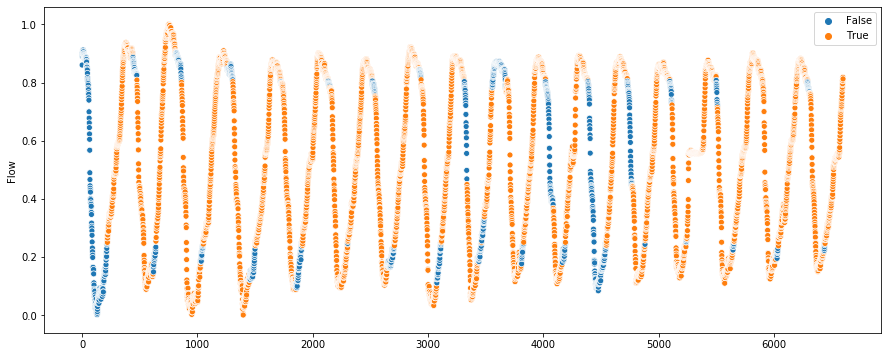

In [153]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow_test['Flow'], x = range(0, len(flow_test['Flow'])), hue = score)